# Plotting the HD 163296 Model

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import astropy.constants as c
import astropy.units as u

au = c.au.cgs.value

%matplotlib inline

Set properties of the observations

In [2]:
# Andrews

dpc = 101.
beam_as = (0.048, 0.038)
rms_muJ = 23e-6

In [3]:
# Isella

dpc = 101.
beam_as = (0.22, 0.15)
rms_muJ = 8.9e-5

Calculate beam area in square arcseconds, in sterad, and average size in au

In [4]:
beam_sas = np.pi * np.prod(beam_as) / (4.*np.log(2.))
beam_sr  = (beam_sas * u.arcsec**2).to('sr').value
beam_cm  = np.sqrt(np.prod(beam_as)) * dpc * au
I_rms    = (rms_muJ * u.Jy / beam_sr).cgs.value

# Read & plot Bernats data

In [5]:
r_1, int_1, int_2 = np.loadtxt('best_fit/best_fit_RicciOp.txt', delimiter=',')

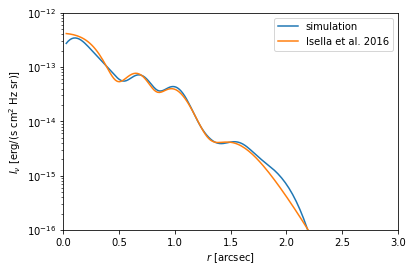

In [6]:
f, ax = plt.subplots()
ax.semilogy(r_1, int_1, label='simulation')
ax.semilogy(r_1, int_2, label='Isella et al. 2016')
ax.set_xlim(0, 3)
ax.set_ylim(1e-16,1e-12)
leg = ax.legend(facecolor='none')
ax.set_xlabel(r'$r$ [arcsec]')
ax.set_ylabel(r'$I_\nu$ [erg/(s cm$^2$ Hz sr)]')
f.savefig('hd163296_comparison.pdf', transparent=True)

# Read and analyze dustpy output

In [7]:
import dustpy
from dustpy.plotting.plot import readFilesFromDir, readFieldFromFile
import h5py
import dsharp_opac as op
from helper import planck_B_nu, convolve, get_dsharp_data
from scipy.interpolate import interp2d

Read duspty output

In [8]:
files = readFilesFromDir('trial_2_2_1', 'data*.hdf5')
i_file = -1

print(f'reading data from {files[i_file]}')

sig_d = readFieldFromFile('dust/Sigma', files[i_file])[()]
a = readFieldFromFile('dust/a', files[i_file])[0, :][()]
r = readFieldFromFile('grid/r', files[i_file])[()]
T = readFieldFromFile('gas/T', files[i_file])[()]

r_as = r / au / dpc

reading data from trial_2_2_1/data0050.hdf5


Load opacity and interpolate on desired grid & wavelengths

In [9]:
with np.load(op.get_datafile('default_opacities_smooth.npz')) as f:
    a_op  = f['a']
    lam   = f['lam']
    k_abs = f['k_abs']
    k_sca = f['k_sca']
    g     = f['g']
    rho_s = f['rho_s']

# pick 2 wavelength and interpolate the opacities on those wavelengths

lam_mm = np.array([0.1, 0.13])
nu = c.c.cgs.value / lam_mm

f_int = interp2d(np.log10(a_op), np.log10(lam), np.log10(k_abs.T))
k_abs = 10.**f_int(a, lam_mm)

Calculate optical depth and intensity

In [10]:
tau = (sig_d[:, None, :] * k_abs[None, ...]).sum(-1)
I_nu = planck_B_nu(nu, T) * (1 - np.exp(-tau))

/Users/birnstiel/Desktop/hd163296_bestfit/helper.py:73: RuntimeWarning: divide by zero encountered in log10
  I_lin = 10**np.interp(np.log10(r_lin), np.log10(r), np.log10(I_nu))


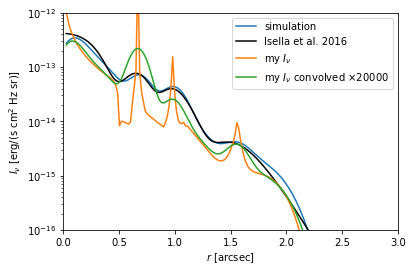

In [11]:
fact = 2e4
I_conv = convolve(r, I_nu[:, 1], beam_cm)

f, ax = plt.subplots()
ax.semilogy(r_1, int_1, label='simulation')
ax.semilogy(r_1, int_2, 'k-', label='Isella et al. 2016')
ax.semilogy(r_as, I_nu[:, 1] * fact, label=r'my $I_\nu$')
ax.semilogy(r_as, I_conv * fact, label=r'my $I_\nu$ convolved $\times$'+f'{fact:g}')
ax.set_xlim(0, 3)
ax.set_ylim(1e-16, 1e-12)
leg = ax.legend(facecolor='none')
ax.set_xlabel(r'$r$ [arcsec]')
ax.set_ylabel(r'$I_\nu$ [erg/(s cm$^2$ Hz sr)]')
f.savefig('hd163296_comparison.pdf', transparent=True)

# Check the convolution

Get `DSHARP` data

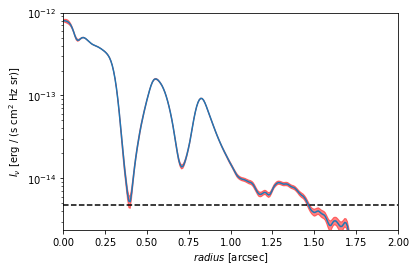

In [12]:
r_dsharp, I_dsharp, dI_nu = get_dsharp_data()

In [13]:
I_dc = convolve(r_dsharp, I_dsharp, beam_cm / au / dpc)

/Users/birnstiel/Desktop/hd163296_bestfit/helper.py:73: RuntimeWarning: invalid value encountered in log10
  I_lin = 10**np.interp(np.log10(r_lin), np.log10(r), np.log10(I_nu))


Text(0,0.5,'$I_\\nu$ [erg/(s cm$^2$ Hz sr)]')

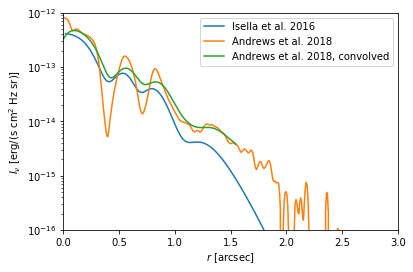

In [14]:
f, ax = plt.subplots()
ax.semilogy(r_1 * 1/1.22, int_2, '-', label='Isella et al. 2016')
ax.semilogy(r_dsharp, I_dsharp, '-', label='Andrews et al. 2018')
ax.semilogy(r_dsharp, I_dc, '-', label='Andrews et al. 2018, convolved')

ax.set_xlim(0, 3)
ax.set_ylim(1e-16, 1e-12)
leg = ax.legend(facecolor='none')
ax.set_xlabel(r'$r$ [arcsec]')
ax.set_ylabel(r'$I_\nu$ [erg/(s cm$^2$ Hz sr)]')